In [24]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [25]:
def default_birth_func(ind):
    return 1

def default_death_func(ind):
    return 1 + (ind.active + ind.inactive - ind.compensating) * 10**-2

class individual(object):
    
    def __init__(self, active, inactive, compensating, p_full_insert, p_partial_insert, p_deactivate, p_compensate):
        if compensating > (inactive+active):
            raise ValueError('The number of compensating mutations must be less than or equal to the number of retroelements')
        self.active = active
        self.inactive = inactive
        self.compensating = compensating
        self.p_full_insert = p_full_insert
        self.p_partial_insert = p_partial_insert
        self.p_deactivate = p_deactivate
        self.p_compensate = p_compensate

    def __repr__(self):
        stract = "active retroelements: " + str(self.active)
        strinact = "inactive retroelemnts: " + str(self.inactive)
        strcomp = "compensating mutations: " + str(self.compensating)
        strprobs = "p_full_insert: " + str(self.p_full_insert) + ', p_partial_insert: ' +str(self.p_partial_insert) + \
                   ", p_deactivate: " + str(self.p_deactivate) + ', p_compensate: ' + str(self.p_compensate)
        return stract + '\n' + strinact + '\n' + strcomp + '\n' + strprobs + '\n'
    
    def reproduce(self):
        return copy.deepcopy(self)
    
    def mutate(self, dt):
        full_inserts = np.random.poisson(self.active*self.p_full_insert*dt)
        partial_inserts = np.random.poisson(self.active*self.p_partial_insert*dt)
        deactivations = np.random.binomial(self.active, self.p_deactivate*dt)
        if (self.active + self.inactive - self.compensating) > 0:
            compensations = np.random.binomial(self.active + self.inactive - self.compensating, self.p_compensate*dt)
        else:
            compensations = 0
        self.active = self.active + full_inserts - deactivations
        self.inactive = self.inactive + partial_inserts + deactivations
        self.compensating = self.compensating + compensations


class rtePopulation(object):
    
    def __init__(self, individual_list, birth_function, death_function, max_pop_size):
        self.birth_function = birth_function
        self.death_function = death_function
        self.population = {index: (ind, birth_function(ind), death_function(ind), None) for index, ind
                           in enumerate(individual_list)}
        self.max_pop_size = max_pop_size
        self.max_who = len(self.population)-1
        
    def __repr__(self):
        return repr(self.population)

    def reproduce(self, who):
        indiv = self.population[who][0]
        new_who = self.max_who + 1
        if new_who not in self.population:
            self.population[new_who] = (indiv.reproduce(), self.birth_function(indiv), self.death_function(indiv), who)
        else:
            raise KeyError('this individual already exists! Error in numbering scheme')
        self.max_who = self.max_who + 1

    def die(self,who):
        return self.population.pop(who)

    def active_rtes(self):
        return np.array([cell[0].active for cell in self.population.values()])
    
    def inactive_rtes(self):
        return np.array([cell[0].inactive for cell in self.population.values()])
    
    def compensating_mutations(self):
        return np.array([cell[0].compensating for cell in self.population.values()])

    def birth_functions(self):
        return np.array([cell[1] for cell in self.population.values()])
    
    def death_functions(self):
        return np.array([cell[2] for cell in self.population.values()])

    def births(self, dt):
        if dt >= 1:
            raise ValueError('dt must be less than 1')
        pop_size = len(self.population)
        gap = self.max_pop_size-pop_size
        births = gap*dt
        who_reproduces = np.random.choice([who for who in self.population],int(births))
        for who in who_reproduces:
            self.reproduce(who)

    def deaths(self, dt):
        if dt >= 1:
            raise ValueError('dt must be less than 1')
        die_list = []
        for who in self.population:
            death_rate = self.population[who][2]*dt
            if np.random.uniform(0,1) < death_rate:
                die_list.append(who)
        for who in die_list:
            self.die(who)

    def mutations(self, dt):
        for indiv in self.population.values():
            indiv[0].mutate(dt)

    def update(self, dt):
        self.mutations(dt)
        self.deaths(dt)
        self.births(dt)

In [44]:
test_cell = individual(10, 0, 0, 10**-2.5, 10**-2, 10**-3, 10**-4)

In [45]:
test_cell

active retroelements: 10
inactive retroelemnts: 0
compensating mutations: 0
p_full_insert: 0.0031622776601683794, p_partial_insert: 0.01, p_deactivate: 0.001, p_compensate: 0.0001

In [46]:
pop_size=1000
test_ind_list = [copy.deepcopy(test_cell) for i in range(pop_size)]
test_pop = rtePopulation(test_ind_list, default_birth_func, default_death_func, pop_size)

In [67]:
#mean_active=[]
#mean_inactive=[]
#mean_compensating=[]
for gen in range(300):
    for i in range(10):
        test_pop.update(.1)
    mean_active.append(np.mean(test_pop.active_rtes()))
    mean_inactive.append(np.mean(test_pop.inactive_rtes()))
    mean_compensating.append(np.mean(test_pop.compensating_mutations()))

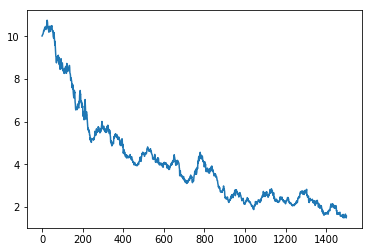

In [68]:
plt.plot(mean_active)

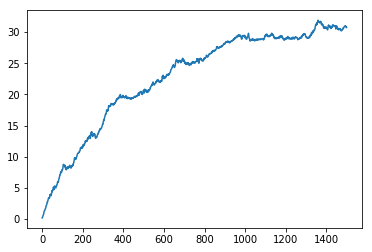

In [69]:
plt.plot(mean_inactive)

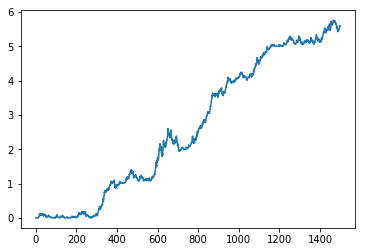

In [70]:
plt.plot(mean_compensating)

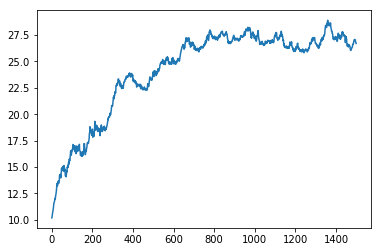

In [71]:
plt.plot(np.array(mean_active)+np.array(mean_inactive)-np.array(mean_compensating))